## Transformer预测电池容量序列，优化方式为最小化所有预测值的mse

In [14]:
import numpy as np
import random
import math
import time
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [15]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [16]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)


# leave-one-out evaluation: one battery is sampled randomly; the remainder are used for training.
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v['capacity'], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [17]:
'''
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'datasets/CALCE/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result
'''

"\nBattery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']\n\ndir_path = 'datasets/CALCE/'\nBattery = {}\nfor name in Battery_list:\n    print('Load Dataset ' + name + ' ...')\n    path = glob.glob(dir_path + name + '/*.xlsx')\n    dates = []\n    for p in path:\n        df = pd.read_excel(p, sheet_name=1)\n        print('Load ' + str(p) + ' ...')\n        dates.append(df['Date_Time'][0])\n    idx = np.argsort(dates)\n    path_sorted = np.array(path)[idx]\n    \n    count = 0\n    discharge_capacities = []\n    health_indicator = []\n    internal_resistance = []\n    CCCT = []\n    CVCT = []\n    for p in path_sorted:\n        df = pd.read_excel(p,sheet_name=1)\n        print('Load ' + str(p) + ' ...')\n        cycles = list(set(df['Cycle_Index']))\n        for c in cycles:\n            df_lim = df[df['Cycle_Index'] == c]\n            #Charging\n            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]\n            c_v = df_c['Voltage(V)']\n            c_c = df

### 备用导入：CALCE.npy

In [18]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery = np.load('datasets/CALCE/CALCE.npy', allow_pickle=True)
Battery = Battery.item()

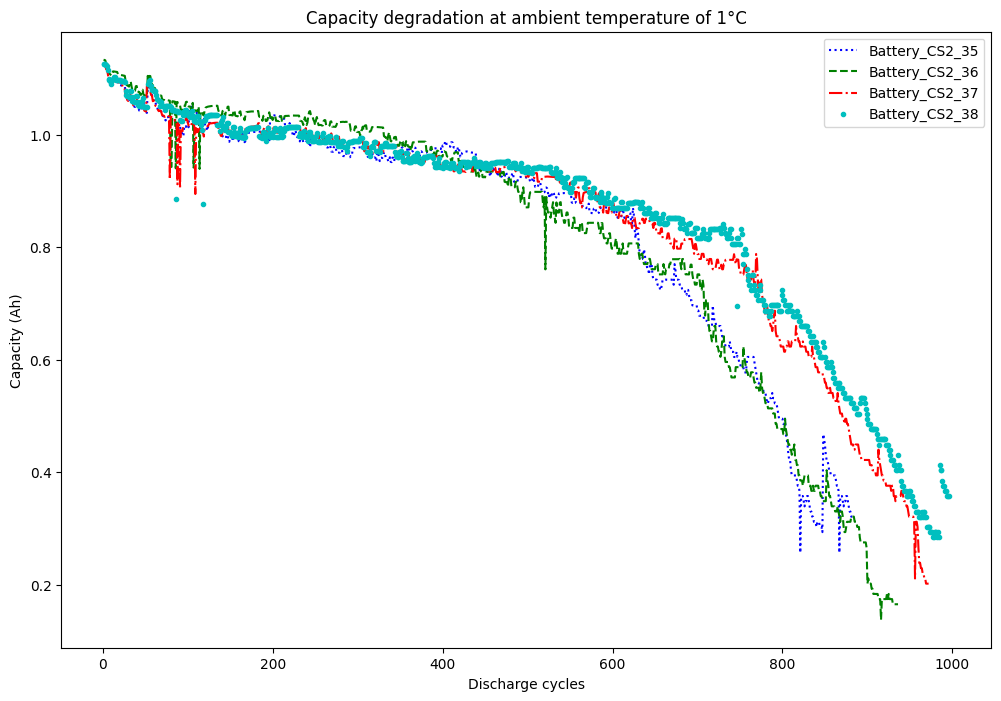

In [19]:
#Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

In [20]:
class Autoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_dim=8, noise_level=0.001):
        super(Autoencoder, self).__init__()
        self.input_size, self.hidden_dim, self.noise_level = input_size, hidden_dim, noise_level
        self.fc1 = nn.Linear(self.input_size, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.input_size)
        
    def encoder(self, x):
        x = self.fc1(x)
        h1 = F.relu(x)
        return h1
    
    def mask(self, x):
        corrupted_x = x + self.noise_level * torch.randn_like(x)
        return corrupted_x
    
    def decoder(self, x):
        h2 = self.fc2(x)
        return h2
    
    def forward(self, x):
        out = self.mask(x)
        encode = self.encoder(out)
        decode = self.decoder(encode)
        return encode, decode
    
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.0, max_len=16):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].squeeze(1)
        return x    
    
    
class Net(nn.Module):
    def __init__(self, feature_size=16, hidden_dim=32, num_layers=1, nhead=8, dropout=0.0, noise_level=0.01):
        super(Net, self).__init__()
        self.auto_hidden = int(feature_size/2)
        input_size = self.auto_hidden 
        self.pos = PositionalEncoding(d_model=input_size)
        encoder_layers = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.cell = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.linear1 = nn.Linear(input_size, 1)
        self.linear2 = nn.Linear(int(input_size/2), 1)
        self.autoencoder = Autoencoder(input_size=feature_size, hidden_dim=self.auto_hidden, noise_level=noise_level)
 
    def forward(self, x): 
        batch_size, feature_num, feature_size  = x.shape 
        encode, decode = self.autoencoder(x.reshape(batch_size, -1))# batch_size*seq_len
        out = encode.reshape(batch_size, -1, self.auto_hidden)
        out = self.pos(out)
        out = out.reshape(1, batch_size, -1) # (1, batch_size, feature_size)
        out = self.cell(out)                 # shape (1, batch_size, feature_size)
        out = out.reshape(batch_size, -1)    # (batch_size, hidden_dim)
        out = self.linear1(out)              # (batch_size, 1)
        
        return out, decode

In [21]:
def train(lr=0.01, feature_size=8, hidden_dim=32, num_layers=1, nhead=8, weight_decay=0.0, EPOCH=1000, seed=0, 
         alpha=0.0, noise_level=0.0, dropout=0.0, metric='re', is_load_weights=True):
    score_list, result_list = [], []
    Rated_Capacity=1.1
    
    for i in range(4):
        name = Battery_list[i]
        window_size = feature_size
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)
        train_size = len(train_x)
        print('sample size: {}'.format(train_size))

        setup_seed(seed)
        global model
        model= Net(feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, dropout=dropout,
                    noise_level=noise_level)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        '''
        # save ramdom data for repetition
        if torch.__version__.split('+')[0] >= '1.6.0':
            torch.save(model.state_dict(), 'model_CALCE'+str(seed)+'.pth')
        else:
            torch.save(model.state_dict(), 'model_CALCE.pth', _use_new_zipfile_serialization=False)
         '''

        # load the random data generated by my device
        if is_load_weights: 
            if torch.__version__.split('+')[0] >= '1.6.0':
                model.load_state_dict(torch.load('initial_weights/model_CALCE.pth')) 
            else:
                model.load_state_dict(torch.load('initial_weights/model_CALCE_1.5.0.pth'))
                
        test_x = train_data.copy()
        loss_list, y_ = [0], []
        rmse, re = 1, 1
        score_, score = [1], [1]
        X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)#(batch_size, seq_len, input_size)
        y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)# shape 为 (batch_size, 1)

        X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
        for epoch in range(EPOCH):

            output, decode = model(X)
            output = output.reshape(-1, 1)
            loss = criterion(output, y) + alpha * criterion(decode, X.reshape(-1, feature_size))
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%10 == 0:
                test_x = train_data.copy()
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device) # (batch_size,feature_size=1,input_size)
                    pred, _ = model(x)                 # pred shape (batch_size=1, feature_size=1)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)     # The test values are added to the original sequence to continue to predict the next point
                    point_list.append(next_point) # Saves the predicted value of the last point in the output sequence
                y_.append(point_list)             # Save all the predicted values
                loss_list.append(loss)
                rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                print('epoch:{:<2d} | loss:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, rmse, re))
            if metric == 're':
                score = [re]
            elif metric == 'rmse':
                score = [rmse]
            else:
                score = [re, rmse]
            if (loss < 0.001) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(y_[-1])
    return score_list, result_list

### 参数优化

In [22]:
Rated_Capacity = 1.1
window_size = 64
feature_size = window_size
dropout = 0.0
EPOCH = 500
nhead = 16
weight_decay = 0.0
noise_level = 0.0
alpha = 0.01
lr = 0.0005    # learning rate
hidden_dim = 32
num_layers = 1
is_load_weights = False
metric = 'mse'

seed = 0
SCORE = []
print('seed:{}'.format(seed))
score_list, output = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, 
                      weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout=dropout, alpha=alpha, 
                      noise_level=noise_level, metric=metric, is_load_weights=is_load_weights)
print(np.array(score_list))
print(metric + ': {:<6.4f}'.format(np.mean(np.array(score_list))))
print('------------------------------------------------------------------')
for s in score_list:
    SCORE.append(s)

print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))



seed:0
sample size: 2713
epoch:9  | loss:0.0307 | RMSE:0.2116 | RE:1.0000
epoch:19 | loss:0.1142 | RMSE:0.4345 | RE:1.0000
epoch:29 | loss:0.0279 | RMSE:0.2055 | RE:1.0000
epoch:39 | loss:0.0358 | RMSE:0.2468 | RE:0.9826
epoch:49 | loss:0.0236 | RMSE:0.2045 | RE:1.0000
epoch:59 | loss:0.0226 | RMSE:0.2094 | RE:1.0000
epoch:69 | loss:0.0193 | RMSE:0.2032 | RE:1.0000
epoch:79 | loss:0.0170 | RMSE:0.2019 | RE:1.0000
epoch:89 | loss:0.0149 | RMSE:0.2020 | RE:1.0000
epoch:99 | loss:0.0129 | RMSE:0.2004 | RE:1.0000
epoch:109 | loss:0.0111 | RMSE:0.1997 | RE:1.0000
epoch:119 | loss:0.0094 | RMSE:0.1990 | RE:1.0000
epoch:129 | loss:0.0079 | RMSE:0.1976 | RE:1.0000
epoch:139 | loss:0.0065 | RMSE:0.1964 | RE:1.0000
epoch:149 | loss:0.0053 | RMSE:0.1948 | RE:1.0000
epoch:159 | loss:0.0043 | RMSE:0.1928 | RE:1.0000
epoch:169 | loss:0.0034 | RMSE:0.1905 | RE:1.0000
epoch:179 | loss:0.0027 | RMSE:0.1876 | RE:1.0000
epoch:189 | loss:0.0022 | RMSE:0.1843 | RE:1.0000
epoch:199 | loss:0.0018 | RMSE:0.18

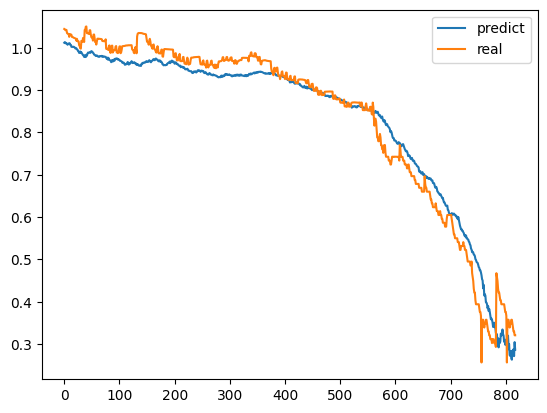

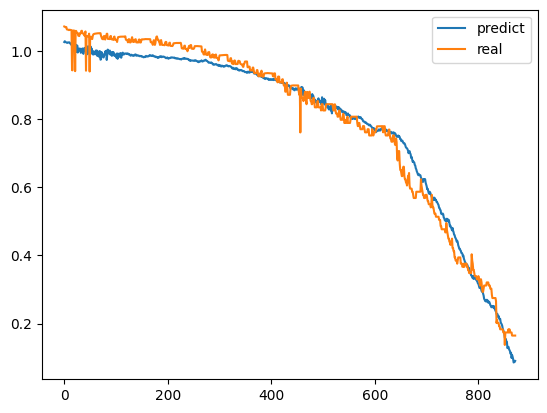

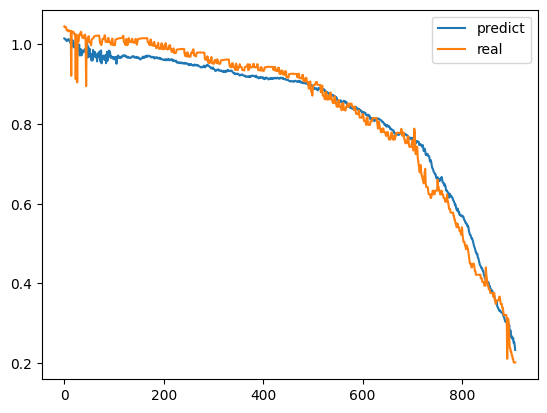

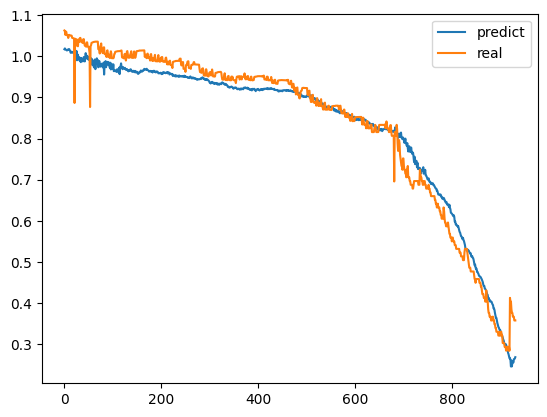

[0.040713156395466715, 0.03842968234241578, 0.03255391140345329, 0.03478976383673598]


In [23]:
#将Battery数据集转换为时间序列数据集
def data_transform(data, window_size=64):
    data_x, data_y = [], []
    for i in range(len(data)-window_size):
        data_x.append(data[i:i+window_size])
        data_y.append(data[i+window_size])
    return np.array(data_x), np.array(data_y)
#进行转换




#用model单步预测
def predict(model, x):
    x = np.reshape(np.array(x),(-1, 1, feature_size)).astype(np.float32)
    x = torch.from_numpy(x).to(device) # (batch_size,feature_size=1,input_size)
    pred, _ = model(x)                 # pred shape (batch_size=1, feature_size=1)
    next_point = pred.data.cpu().numpy()[0,0]
    return next_point

#计算rmse
def rmse(predict, real):
    return np.sqrt(np.mean(np.square(predict - real)))
    

#生成预测序列
rmse_list=[]

for i in range(4):
    input,real = data_transform(Battery[Battery_list[i]]["capacity"], 64)
    predict_list = []
    for j in range(len(input)):
        predict_list.append(predict(model,input[j]))
    #计算mse
    predict_ndarray = np.array(predict_list)
    rmse_list.append(rmse(predict_ndarray, real))
    plt.plot(predict_list, label="predict")
    plt.plot(real, label="real")
    plt.legend()
    plt.show()

print(rmse_list)

In [24]:

#计算到失效的剩余循环次数
def get_rul(data, threshold,model,window_size=64):
    count=1
    input=data
    next=predict(model,input)
    while next>threshold:
        input_tem=np.zeros(window_size)
        input_tem[0:-1]=input[1:]
        input_tem[-1]=next
        input=input_tem
        next=predict(model,input)
        count+=1
    
    return count

In [25]:
#计算所有rul
def get_rul_list(datas, threshold,model,window_size=64):
    rul_list=[]
    for data in datas:
        # if data[-1]<threshold:
        #     break
        rul=get_rul(data, threshold,model,window_size)
        rul_list.append(rul)
        if rul==1:
            break
    return rul_list

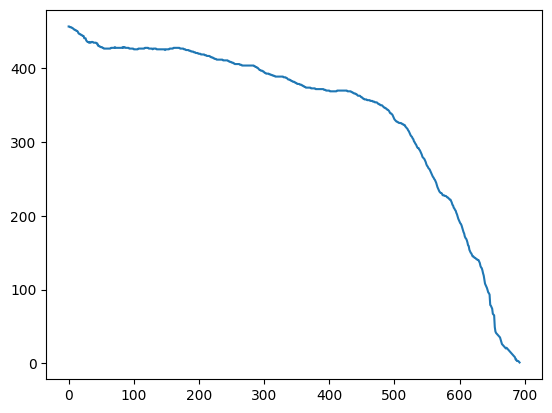

In [28]:
#对4块电池进行rul计算
window_size=64
#失效阈值
threshold = 0.77
input,real = data_transform(Battery[Battery_list[2]]["capacity"], 64)
rul_list=get_rul_list(input,threshold,model,window_size)
plt.plot(rul_list)
plt.show()

In [29]:
predict(model,input[458])
get_rul(input[459],threshold,model,window_size)

357

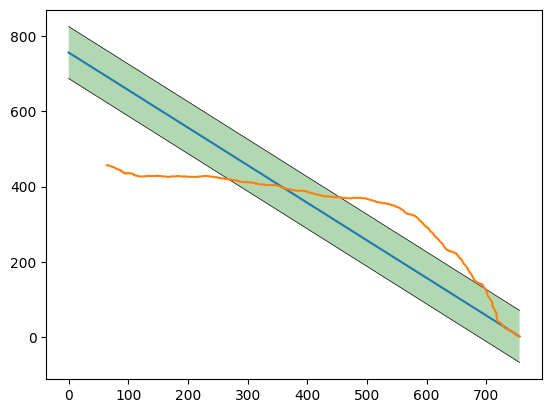

In [30]:
#画一条经过(len(rul_list)+window_size,0),斜率为-1的直线

#画出直线的90%置信区间
x=np.arange(len(rul_list)+window_size)
y=-x+len(rul_list)+window_size
y1=-x+len(rul_list)+window_size+0.1*len(rul_list)
y2=-x+len(rul_list)+window_size-0.1*len(rul_list)
#在其中填充颜色
plt.fill_between(x,y1,y2,where=y1>=y2,facecolor='green',alpha=0.3)

plt.plot(x,y)
plt.plot(x,y1,'-',color='black',linewidth=0.5)
plt.plot(x,y2,'-',color='black',linewidth=0.5)


xx=np.arange(window_size,len(rul_list)+window_size)
yy=rul_list
plt.plot(xx,yy)



plt.show()

In [ ]:
# #可视化展示output

# import matplotlib.pyplot as plt
# %matplotlib inline

# for i in range(len(output)):
#     plt.figure(figsize=(10, 3))
#     plt.plot(output[i], label='predict')
#     plt.plot(Battery[Battery_list[i]]["capacity"], label='true')
#     plt.legend()
#     plt.title('Battery '+Battery_list[i])
#     plt.show()

### 网格搜索法

In [ ]:
#选择是否进行网格搜索法
is_optimise = False
if is_optimise:
    Rated_Capacity = 1.1
    window_size = 64
    feature_size = window_size
    dropout = 0.0
    EPOCH = 500
    nhead = 16
    is_load_weights = False
    weight_decay = 0.0
    noise_level = 0.0
    num_layers = 1
    metric = 're'

    states = {}
    for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]:
        for hidden_dim in [16, 32, 64]:
            for alpha in [1e-4, 1e-3, 1e-2]:
                show_str = 'lr={}, num_layers={}, hidden_dim={}'.format(lr, num_layers, hidden_dim)
                print(show_str)
                SCORE = []
                for seed in range(5):
                    print('seed:{}'.format(seed))
                    score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, 
                                        weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout=dropout, alpha=alpha, 
                                        noise_level=noise_level, metric=metric, is_load_weights=is_load_weights)
                    print(np.array(score_list))
                    print(metric + ': {:<6.4f}'.format(np.mean(np.array(score_list))))
                    print('------------------------------------------------------------------')
                    for s in score_list:
                        SCORE.append(s)

                print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))
                states[show_str] = np.mean(np.array(SCORE))
                print('===================================================================')
                
    min_key = min(states, key = states.get)
    print('optimal parameters: {}, result: {}'.format(min_key, states[min_key]))